# Comparativo de datos de PM<sub>10</sub>  - Smart Citizen/Semadet

Este notebook muestra el proceso que se siguió para realizar la comparación de los datos de PM<sub>10</sub> registrados por los sensores [Smart Citizen](https://smartcitizen.me/kits/) y los datos interpolados de de las estaciones de monitoreo de la Secretaría de Medio Ambiente y Desarrollo Territorial del Estado de Jalisco (Semadet). Los datos con los que se trabaja fueron recopilados del portal de la api de Smart Citizen y del portal de la Seamdet y se encuentran guardados en la base de datos del proyecto [Prototipos de Infraestructura Pública para una Ciudad del Futuro](https://pipciudadfuturo.com/).

El notebook consta de las siguientes partes:

+ Librerías utilizadas
+ Descarga de datos
+ Construyendo un ejemplo
+ Código para comparación 2021

## Librerías

Para interactuar con la base de datos y generar el procesmiento de los diferentes datos hemos desarrollado una librería propia `aqiGDL` que almacena las diferentes funciones que son requeridas para el trabajo. Además de la librería desarrollada por [LAC](https://lac.mx) para el proyecto, también se utilizan otras librerías de python para el análisis y visualización de datos.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy import stats
import datetime
import textwrap
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aqiGDL
%matplotlib inline

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Estilos visuales
Utilizamos el estilo visual "Pitaya Smoothie" para la generación de gráficas.

In [2]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
colors = ['7A76C2', 'ff6e9c98', 'f62196', '18c0c4', 'f3907e', '66E9EC']

## Descarga de datos

### Datos históricos de calidad del aire registrados por los sensores

Los datos históricos de exposición a contaminantes atmosféricos durante desplazamientos han sido descargados desde la api de Smart Citizen. Actualmente los datos están disponibles desde la base de datos de PIP.

In [3]:
gdf = aqiGDL.gdf_from_db('smartcitizen', 'public')
gdf.drop_duplicates(inplace=True)
print(gdf.shape)
gdf.head(5)

(176643, 8)


,device_id,param,unit,lon,lat,date,value,geometry
0,13492,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.389891,20.651647,2021-07-08T22:00:39Z,41.285714,POINT (667738.643 2284426.650)
1,13492,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.389891,20.651647,2021-07-08T21:00:18Z,76.783333,POINT (667738.643 2284426.650)
2,13492,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.389891,20.651647,2021-07-08T20:00:16Z,255.616667,POINT (667738.643 2284426.650)
3,13492,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.389891,20.651647,2021-07-08T19:00:48Z,219.525424,POINT (667738.643 2284426.650)
4,13492,Total Volatile Organic Compounds Digital Indoo...,ppb,-103.389891,20.651647,2021-07-08T18:03:40Z,161.892857,POINT (667738.643 2284426.650)


De los parámetros que se miden por Smart Citizen el que se va a utilizar para la construcción de la línea base será el de dióxido de carbono equivalente, medido en partes por millón (ppm).

In [4]:
gdf.loc[gdf.param=='Particle Matter PM 10'].head(2)

,device_id,param,unit,lon,lat,date,value,geometry
811,13492,Particle Matter PM 10,ug/m3,-103.389891,20.651647,2021-07-02T14:00:37Z,31.076923,POINT (667738.643 2284426.650)
812,13492,Particle Matter PM 10,ug/m3,-103.389891,20.651647,2021-07-02T13:00:31Z,33.033333,POINT (667738.643 2284426.650)


### Red vial de Guadalajara

Con [OSMnx](https://osmnx.readthedocs.io/en/stable/) se descarga la red vial para el área de los sensores

In [5]:
G = ox.graph_from_bbox(20.7900,20.523110,-103.2400,-103.4700)
edges = ox.graph_to_gdfs(G, nodes=False)

### GeoDataFrame con ubicación de sensores

A partir de la tabla que se encuentra en la base de datos de PIP podemos hacer una agrupación por identificador del dispositivo de medición, al agrupar esta obtenemos las coordenadas de cada dispositivo. Al guardar estos datos en una nueva tabla podemos acceder a las ubicacioens más adelante.

In [6]:
gdf_est = gdf[['device_id','lon','lat']].groupby('device_id').mean()
gdf_est = gpd.GeoDataFrame(
    gdf_est, geometry=gpd.points_from_xy(gdf_est.lon, gdf_est.lat))
gdf_est.head(2)

,lon,lat,geometry
device_id,,,
13483,-103.351588,20.685147,POINT (-103.35159 20.68515)
13492,-103.389890,20.651647,POINT (-103.38989 20.65165)


### Datos históricos de calidad del aire

Los datos históricos de calidad del aire para el Área Metropolitana de Guadalajara ya han sido descargados de las bases de datos de SEMADET. Una vez descargados fueron procesado (revisión de fechas, otuliers, etc.) y validados para ser utilizados. Actualmente los datos limpios están disponibles desde la base de datos de PIP.

Con la siguiente línea de código se realiza la descarga de datos horarios históricos desde el 31 de Diciembre del 2013 al 31 de Diciembre del 2019.

In [7]:
df = aqiGDL.download_simaj_clean_data(time_period='hour')
df.head(5)

,FECHA,HORA,PARAM,EST_SIMAJ,CONC,LONG,LAT
1314599,2014-01-01,11:00,SO2,SFE,0.001,-103.377179,20.529149
1314394,2014-01-01,07:00,SO2,CEN,0.012,-103.333336,20.673765
1314395,2014-01-01,07:00,SO2,VAL,0.003,-103.398551,20.680193
1314396,2014-01-01,07:00,SO2,AGU,NaN,-103.416431,20.631268
1314397,2014-01-01,07:00,SO2,MIR,0.008,-103.343333,20.614444


### GeoDataFrame con ubicación de sensores

Al igual que con los sensores de Smart Citizen se puede construir un GeoDataFrame con la localización de los sensores de la Semadet.

In [8]:
simaj_est = df[['EST_SIMAJ','LONG','LAT']].groupby('EST_SIMAJ').mean()
simaj_est = gpd.GeoDataFrame(
    simaj_est, geometry=gpd.points_from_xy(simaj_est.LONG, simaj_est.LAT))
simaj_est = simaj_est.set_crs("EPSG:4326")
simaj_est.head(2)

,LONG,LAT,geometry
EST_SIMAJ,,,
AGU,-103.416431,20.631268,POINT (-103.41643 20.63127)
ATM,-103.355435,20.719674,POINT (-103.35543 20.71967)


## Construyendo un ejemplo

Debido a que los datos registrados por Smart Citizen son para el año 2021 y los datos de la Semadet únicamente se encuentran publicados hasta el año 2019 es necesario consrtuir un ejemplo de la metodología para el desarrollo del método comparativo de los datos, si bien las conclusiones que se generen de este no van a ser adecuadas sí marcan la ruta de qué pasos se deben de seguir y cómo se debe de interpretar la información.

El primer paso es filtrar la información para únicamente incluir información del parámetro de material particulado menor a 10 micras (PM<sub>10</sub>). En el ejemplo se va a mostrar el proceso que se siguió únicamente con una estación, aunque más adelante se deja todo listo para que se haga con todas las estaciones.

In [9]:
gdf_param = gdf.loc[(gdf.device_id==13483)&(gdf.param=='Particle Matter PM 10')]
print('La forma del nuevo GeoDataFrame es: ',gdf_param.shape)
gdf_param.head(2)

La forma del nuevo GeoDataFrame es:  (1007, 8)


,device_id,param,unit,lon,lat,date,value,geometry
50427,13483,Particle Matter PM 10,ug/m3,-103.351588,20.685147,2021-03-03T15:00:38Z,27.225806,POINT (671692.111 2288175.175)
50428,13483,Particle Matter PM 10,ug/m3,-103.351588,20.685147,2021-03-03T14:00:08Z,36.551724,POINT (671692.111 2288175.175)


Debido a que los datos no siempre se registran en una hora cerrada, al contrario de como reporta la información la Semadet, se debe de agrupar la información por hora para asegurar que no se generen problemas en la comparativa de datos.

In [10]:
pd.options.mode.chained_assignment = None
gdf_param['date'] = pd.to_datetime(gdf_param['date'])
gdf_param.set_index('date',inplace=True)
gdf_param = gdf_param.resample('H').mean()
gdf_param.dropna(inplace=True)
print(gdf_param.shape)
gdf_param.head(2)

(1007, 4)


,device_id,lon,lat,value
date,,,,
2021-01-20 15:00:00+00:00,13483.0,-103.351588,20.685147,46.777778
2021-01-20 16:00:00+00:00,13483.0,-103.351588,20.685147,43.000000


Como se mencionó anteriormente, este ejemplo se debe de hacer con una estimación por la inaccesibilidad de los datos 2021 de la Semadet. Por lo tanto, se crea una fecha temporal con datos del 2018 para la información recopilada por los sensores Smart Citizen (aunque en realidad son los registros 2021). Esto quiere decir que el día y mes se mantiene igual y solamente cambia el año.

In [11]:
gdf_param.reset_index(inplace=True)
gdf_param['FECHA'] = gdf_param.date.dt.date
gdf_param.FECHA = gdf_param.FECHA.astype('str')
gdf_param['HORA'] = gdf_param.date.dt.time
gdf_param['FECHA_tmp'] = gdf_param.apply(lambda row: '2018-'+str(row.loc['FECHA'][5:7])+str(row.loc['FECHA'][7:]), axis=1)
gdf_param['date_tmp'] = gdf_param['date'] - pd.DateOffset(years=3)
print(gdf_param.shape)
gdf_param.head(5)

(1007, 9)


,date,device_id,lon,lat,value,FECHA,HORA,FECHA_tmp,date_tmp
0,2021-01-20 15:00:00+00:00,13483.0,-103.351588,20.685147,46.777778,2021-01-20,15:00:00,2018-01-20,2018-01-20 15:00:00+00:00
1,2021-01-20 16:00:00+00:00,13483.0,-103.351588,20.685147,43.000000,2021-01-20,16:00:00,2018-01-20,2018-01-20 16:00:00+00:00
2,2021-01-20 17:00:00+00:00,13483.0,-103.351588,20.685147,48.366667,2021-01-20,17:00:00,2018-01-20,2018-01-20 17:00:00+00:00
3,2021-01-20 18:00:00+00:00,13483.0,-103.351588,20.685147,37.000000,2021-01-20,18:00:00,2018-01-20,2018-01-20 18:00:00+00:00
4,2021-01-20 19:00:00+00:00,13483.0,-103.351588,20.685147,38.766667,2021-01-20,19:00:00,2018-01-20,2018-01-20 19:00:00+00:00


Es necesario dar formato a los datos de la Semadet para que se puedan relacionar las fechas y horas a los datos de Smart Citizen.

In [12]:
df_test = df.copy()
df_test['FECHA'] = pd.to_datetime(df_test['FECHA'])
df_test.FECHA = df_test.FECHA.astype('str')
df_test['HORA'] = pd.to_datetime(df_test['HORA'])
df_test['HORA'] = df_test.HORA.dt.time
df_test.head(5)

,FECHA,HORA,PARAM,EST_SIMAJ,CONC,LONG,LAT
1314599,2014-01-01,11:00:00,SO2,SFE,0.001,-103.377179,20.529149
1314394,2014-01-01,07:00:00,SO2,CEN,0.012,-103.333336,20.673765
1314395,2014-01-01,07:00:00,SO2,VAL,0.003,-103.398551,20.680193
1314396,2014-01-01,07:00:00,SO2,AGU,NaN,-103.416431,20.631268
1314397,2014-01-01,07:00:00,SO2,MIR,0.008,-103.343333,20.614444


Con el ajuste en los datos de fechas se hace el proceso que se pretende se siga con los datos 2021. Esto es, a partir de las coordenadas del sensor de Smart Citizen se hace una interpolación a ese punto. Con esto se obtiene el valor interpolado y se puede comparar contra el dato de Smart Citizen.

In [13]:
conc = []
long_int = gdf_param.iloc[10].lon
lat_int = gdf_param.iloc[10].lat

for i in range(len(gdf_param)):
    fecha = str(gdf_param.iloc[i].FECHA_tmp)
    hora = gdf_param.iloc[i].HORA
    
    df_tmp = df_test.loc[(df_test.PARAM=='PM10')&(df_test.FECHA==fecha)&(df_test.HORA==hora)]
    
    conc.append(aqiGDL.interpolate_atpoint(long_int, lat_int, df_tmp))
    
gdf_param['simaj'] = conc
gdf_param.head(2)

,date,device_id,lon,lat,value,FECHA,HORA,FECHA_tmp,date_tmp,simaj
0,2021-01-20 15:00:00+00:00,13483.0,-103.351588,20.685147,46.777778,2021-01-20,15:00:00,2018-01-20,2018-01-20 15:00:00+00:00,17.835023
1,2021-01-20 16:00:00+00:00,13483.0,-103.351588,20.685147,43.000000,2021-01-20,16:00:00,2018-01-20,2018-01-20 16:00:00+00:00,19.808844


Con la siguiente función se obtienen tres datos estadísticos que nos permiten evaluar la diferencia que hay entre los datos. Los estadísticos son:
+ Coeficiente de correlación de Pearson: que nos indica si existe una correlación entre ambas series de valores.
+ Raíz del error cuadrático medio: representa la dispersión que hay entre la diferencia de los valores individuales. Tomando como verdadero el valor interpolado y estimado el de Smart Citizen.
+ Prueba t de Student: indica si hay una diferencia estadísticamente significativa entre las medias de dos poblaciones.

In [14]:
def statistical_analysis(df_sck):
    
    df_sck = df_sck.dropna()
    coef_pearson, p = stats.pearsonr(df_sck.value, df_sck.simaj)
    coef_pearson = round(coef_pearson,2)
    rmse = round(mean_squared_error(df_sck.simaj, df_sck.value, squared=False), 2)
    ttest, pttest = stats.ttest_ind(df_sck.value, df_sck.simaj)
    pttest = round(pttest,2)
    
    return coef_pearson, rmse, pttest

La siguiente función se utiliza para graficar los datos registrados para PM<sub>10</sub> por el sensor de Smart Citizen y los datos interpolados de la Semadet. En el mapa de la izquierda se muestra la ubicación del sensor de Smart Citizen en comparación con el sensor de la Semadet. Por su parte, en la gráfica, o gráficas, de dispersión de la derecha se representan los valores interpolados contra los registrados por Smart Citizen. 

In [15]:
def multigraph_smartcitizen(device, df_sck, gdf_simaj, gdf_est, edges, pearsonr, rmse, ttest, save=False):
    df_time1 = df_sck
    
    datelimit = pd.to_datetime("2018-04-01 00:00").tz_localize('utc')
    
    if len(df_sck[df_sck['date_tmp']>datelimit]) > 0:
        fig, axes = plt.subplots(1,3,figsize=(24,8))
        
        df_time1 = df_sck.loc[df_sck['date_tmp']<datelimit].dropna()
        df_time2 = df_sck.loc[df_sck['date_tmp']>datelimit].dropna()
        
        #second period
        
        axes[2].scatter(df_time2.date, df_time2['value'], zorder=1, label='Smart Citizen Kit')
        axes[2].plot(df_time2.date, df_time2['value'], '--', zorder=2, color='white', alpha=0.2)

        axes[2].scatter(df_time2.date, df_time2['simaj'], zorder=1, color='#f3907e', label='Semadet', alpha=1)
        axes[2].plot(df_time2.date, df_time2['simaj'], '--', zorder=2, color='white', alpha=0.2)
        
        axes[2].tick_params(axis='x',labelrotation=45)
        axes[1].get_shared_y_axes().join(axes[1], axes[2])
        axes[2].set_yticklabels([])
        
        axes[2].legend()
        
        
    else:
        fig, axes = plt.subplots(1,2,figsize=(24,8))
    
    #first period
    axes[1].scatter(df_time1.date, df_time1['value'], zorder=1, label='Smart Citizen Kit')
    axes[1].plot(df_time1.date, df_time1['value'], '--', zorder=2, color='white', alpha=0.2)
    
    axes[1].scatter(df_time1.date, df_time1['simaj'], zorder=1, color='#f3907e', label='Semadet', alpha=1)
    axes[1].plot(df_time1.date, df_time1['simaj'], '--', zorder=2, color='white', alpha=0.2)
    
    axes[1].legend()
    
    axes[1].tick_params(axis='x',labelrotation=45)


    x_ticks = np.arange(0, len(df_sck.date),15)
    
    statistical_analysis=(f'Statistical analysis:\nPearson coeficient score is: {pearsonr}\n RMSE is: {rmse}\n t-test value is {ttest}')
    axes[-1].set_title(statistical_analysis,fontsize=12)

    a00 = axes[0]
    shax = a00.get_shared_x_axes()
    shax.remove(a00)
    edges.plot(ax=axes[0], color='#e8e9eb',linewidth=0.1, zorder=-1)
    edges[(edges['highway']=='primary') | (edges['highway']=='secondary')].plot(ax=axes[0], color='#e8e9eb',linewidth=0.5, zorder=0)
    gdf_simaj.plot(ax=axes[0], color='k', label='Estación Semadet', alpha=0.85, zorder=1)
    gdf_est[gdf_est.index==device].plot(ax=axes[0], color='#ba0d38', label='Estación Smart Citizen Kit', alpha=0.85, zorder=2, markersize=90)
    axes[0].axis('off')
    axes[0].legend()
    estacion = device
    fecha_1 = df_sck.date.min().strftime("%Y-%m-%d")
    fecha_2 = df_sck.date.max().strftime("%Y-%m-%d")
    fig.suptitle(f'Device: {estacion}\n Particulate Matter PM10 (ppm)\n{fecha_1} -- {fecha_2}', fontsize=18)

    if save==True:
        plt.savefig(f'../output/figures/sck_semadet/{device}_{fecha_1}_{fecha_2}.png',dpi=300)

    return plt.show()

En las gráficas resultantes es posible observar que hay dos formatos, uno que contiene solo una gráfica con valores registrados de PM<sub>10</sub> y otra con dos. Esto se debe a que, al analizar los datos pudimos notar que casi todos los sensores dejan de registrar valores a partir de marzo, sin embargo, unos cuantos retoman registros en junio 2021. Esto hizo que hubiera un hueco en los registros y, además de que fuera visualmente confuso, reducía el espacio de la gráfica y no permitía leerla claramente. Para atender esta circunstancia se dividieron los formatos, en las figuras que se muestran dos gráficas de dispersión se retomaron las mediciones en junio y son las que se muestran a la derecha, si solo hay una gráfica el sensor no retomó mediciones. Esta información se puede corroborar en los títulos de lagr gráficas que indican las fechas que se están mostrando y en las etiquetas de las x en la gráfica.
Además, en la gráfica de dispersión se puede observar los resultados de los datos estadísticos del coeficiente de correlación, la raíz del error cuadrático medio y la prueba t de Student.

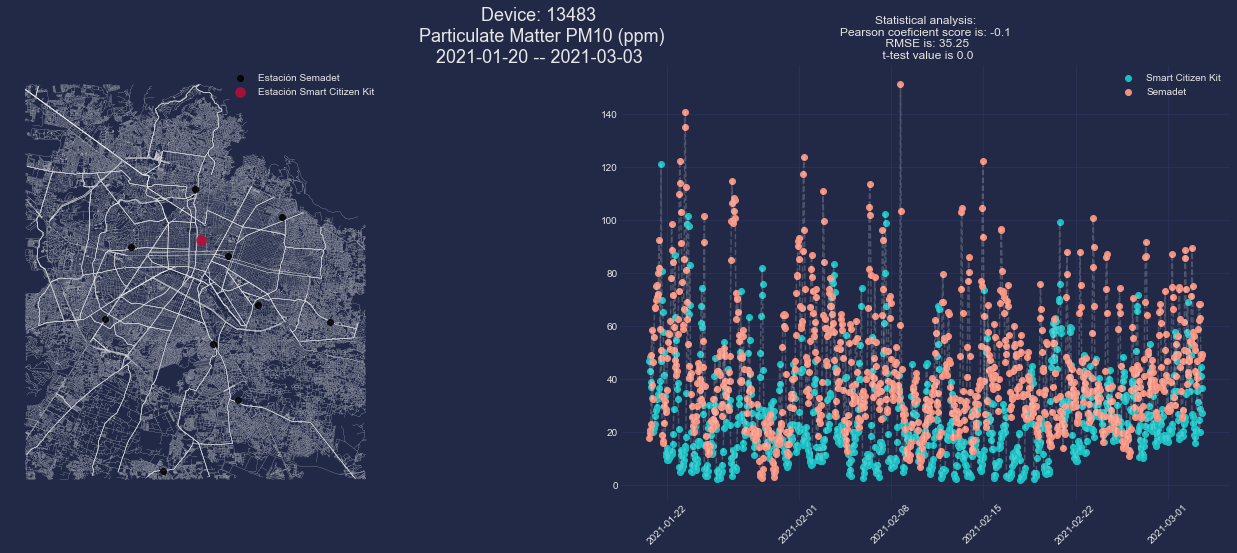

In [16]:
pearsonr, rmse, ttest = statistical_analysis(gdf_param)
multigraph_smartcitizen(13483, gdf_param, simaj_est, gdf_est, edges, pearsonr, rmse, ttest, save=True)

La interpretación de los datos estadísticos es la siguiente:
+ Coeficiente de correlación de Pearson: este valor va entre -1 y 1, donde 1 muestra una correlación positiva y un valor cercano a esto es lo que se esperaría encontrar para los datos entre Smart Citizen y la Semadet. Por su parte, una correlación negativa (-1) o más aun, una correlación inexistente (con valores cercanos a cero) indicarían que los valores no tienen la relación esperada, considerando que se trata del mismo contaminante.
+ Raíz del error cuadrático medio: este dato muestra el valor residual entre los registros interpolados de la Semadet y Smart Citizen, este valor nos indica la magnitud del error, donde un valor menor representa un error (o diferencia) menor.
+ Prueba t de Student: esta prueba nos permite evaluar si la diferencia entre dos medias es estadísticamente significativa, en este caso, el valor que se muestra es el valor de p, que indica la probabilidad de que el estadístico calculado (la Prueba t de Student) sea correcto dada la hipótesis nula. En este caso, la hipótesis nula es que no hay diferencia estadísticamente significativa entre ambas medias, por lo que, con un valor de p mayor a 0.05 no se rechaza hipótesis. Al contrario, si el valor de p es menor a 0.05 se rechaza la hipótesis nula y se considera que las medias son estadísticamente distintas. Para este caso esperaríamos encontrar un valor de p mayor a 0.05.

Algunas consideraciones relevantes son que los valores interpolados tampoco representan un valor certero de la concentración en un punto cualquiera de la ciudad, son simplemente una estimación de la concentración a partir de los datos conocidos, por lo que puede que no registren la realidad de la dinámica atmosférica de un sitio de forma certera. Por otro lado, se desconoce la localización de los sensores de Smart Citizen, esto quiere decir, que si se encuentran al aire libre en un sitio que permita el flujo del aire sin obstrucciones. Debido a que este es uno de los requerimientos para los sensores de la Semadet, en caso de que no se cumpla se puede afectar la medición registrada por el sensor de Smart Citizen y ocasionar desviaciones con respecto al valor oficial.

## Código para comparación 2021

In [ ]:
for est in gdf.device_id.unique:
    
    df_sck = gdf.loc[(gdf.device_id==est)&(gdf.param=='Particle Matter PM 10')]
    
    df_sck['date'] = pd.to_datetime(df_sck['date'])
    df_sck.set_index('date',inplace=True)
    df_sck = df_sck.resample('H').mean()
    df_sck.dropna(inplace=True)
    
    df['FECHA'] = pd.to_datetime(df['FECHA'])
    df.FECHA = df.FECHA.astype('str')
    df['HORA'] = pd.to_datetime(df['HORA'])
    df['HORA'] = df.HORA.dt.time
    
    conc = []
    long_int = df_sck.iloc[10].lon
    lat_int = df_sck.iloc[10].lat

    for i in range(len(df_sck)):
        fecha = str(df_sck.iloc[i].FECHA)
        hora = df_sck.iloc[i].HORA

        df_tmp = df.loc[(df.PARAM=='PM10')&(df.FECHA==fecha)&(df.HORA==hora)]

        conc.append(aqiGDL.interpolate_atpoint(long_int, lat_int, df_tmp))

    df_sck['simaj'] = conc
    
    pearsonr, rmse, ttest = statistical_analysis(df_sck)
    
    multigraph_smartcitizen(est, df_sck, simaj_est, gdf_est, edges, pearsonr, rmse, ttest)